# Classifier Training

***
## Notes

 - http://www.deeplearningbook.org/contents/guidelines.html
 - Determine goals:
 - Establish end-to-end working pipeline:
 - Instrument  the system to determine bottlenecks in performance. Diagnose which components are performing worse, find over/underfitting, defect in data, etc.
 - Repeatedly make incremental changes (gathering new data, adjusting hyperparameters, changing algorithms) based on findings from instrumentation

## Download exported tables locally for use with TensorFlow

In [1]:
# Authenticate Google Drive access
# following guide: https://gsuitedevs.github.io/PyDrive/docs/build/html/quickstart.html
# Need client_secrets.json file for auth to work -- I put it in 'notebooks' folder, but how can we put it somewhere more appropriate and still have the auth find it?
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=207798239714-s97urn6kn6eqj2li0l2k8ud9fudlqqbf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [6]:
# If files are located in Google Drive -- Problem: Need to figure out how to access subfolders, not just root folder. 
# Tables and images are located in respective folders within GEE_exports

# from pydrive.drive import GoogleDrive
# drive = GoogleDrive(gauth)

# # list files in root folder
# file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

# # Get file id of export folder we're saving tables to
# exportFolderID = [file['id'] for file in file_list if file['title']=='GEE_exports'][0] 

# # lists files in export folder
# file_list = drive.ListFile({'q': "'" + exportFolderID + "' in parents and trashed=false"}).GetList()
# for file1 in file_list:
#     print('title: %s, id: %s' % (file1['title'], file1['id']))
    
# # Save all files locally
# for i in range(len(file_list)):
#     file_list[i].GetContentFile('../data/' + file_list[i]['title'])

## SVM

In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV

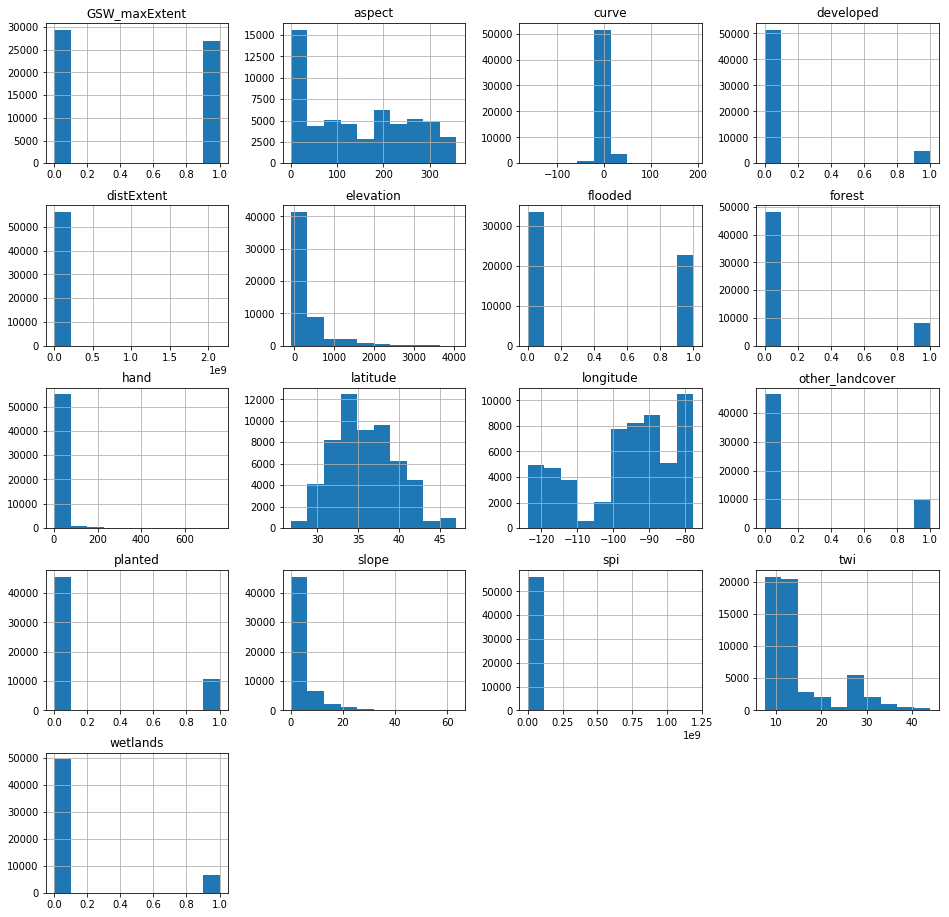

In [327]:
# If files are located on local computer, read tables directly

# CSV of sample points with features
points = pd.read_csv('../data/tables/sample_points.csv')
points.columns
hist = points.hist(figsize=(16, 16))
hist
plt.show()

In [328]:
df = points.copy()

df = df[df.distExtent < 10000000] # Some distExtent values are way too high - remove them

dropCols = pd.concat([df.pop(x) for x in ['latitude','longitude']]) # Pop out imageID, lat, lon so we can check NaN and inf. 

# Check presence of infinite or NaN values
print(' Is NaN?:', np.any(np.isnan(df)), "\n",
     'Is inf?:', not np.any(np.isfinite(df)))

# Remove NaN
df = df.dropna()

# Rescale values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # Using MinMax instead of standard scaler because not all features are normally distributed
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# df_scaled = pd.concat([df_scaled, pd.DataFrame(imageID)]) # Add imageID back. Converting to NaN when I concat so leaving out for now

print(df_scaled)

# Separate features and target
Y = df['flooded'] # Target feature, drop from features
X = df.drop('flooded', axis=1) # Features

# Split data into training and testing sets (split once, use it )
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

# Remove rows with NaN
X_train.dropna()
X_test.dropna()
y_train.dropna()
y_test.dropna()

print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

 Is NaN?: True 
 Is inf?: False
       elevation     slope     curve  GSW_maxExtent  developed  forest  \
0       0.033309  0.047192  0.435028            0.0        0.0     0.0   
1       0.023896  0.034110  0.528249            0.0        0.0     0.0   
2       0.020758  0.071717  0.460452            0.0        0.0     0.0   
3       0.020517  0.123260  0.460452            0.0        0.0     0.0   
4       0.024620  0.038275  0.468927            0.0        0.0     0.0   
5       0.022930  0.091054  0.451977            0.0        0.0     0.0   
6       0.038378  0.198364  0.460452            0.0        0.0     1.0   
7       0.025103  0.107491  0.497175            0.0        0.0     1.0   
8       0.025827  0.045418  0.460452            0.0        0.0     1.0   
9       0.024861  0.206398  0.539548            0.0        0.0     0.0   
10      0.034757  0.055440  0.454802            0.0        0.0     0.0   
11      0.023654  0.087164  0.483051            0.0        0.0     0.0   
12    

In [331]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
start_time = time.time()

# Grid of values for tuning hyperparameters
# C is the 

grid = [{'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
         'tol': [0.0001, 0.001, 0.01, 0.1, 1.0]}]

model = LinearSVC()

gridcv = GridSearchCV(estimator=model, param_grid=grid, return_train_score=True)
gridcv.fit(X_train, y_train)
print('Support Vector Machine Best Score: ' + str(gridcv.best_score_))
print('Best C: ' + str(gridcv.best_estimator_.C))
print('Best tol: ' + str(gridcv.best_estimator_.tol))
print('Grid search runtime: ' + str(timer(start_time, time.time())))

Support Vector Machine Best Score: 0.9198154482539177
Best C: 0.001
Best tol: 1.0
00:05:40.45
Grid search runtime: None


In [332]:
# Benchmark training time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
start_time = time.time()

clf = LinearSVC(C = gridcv.best_estimator_.C, 
                 tol=gridcv.best_estimator_.tol,
                 random_state=0)
clf.fit(X_train, y_train)

print('SVM training runtime: ' + str(timer(start_time, time.time())))

00:00:08.00
SVM training runtime: None


In [333]:
# Performance metrics
from sklearn import metrics
y_pred = clf.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_pred)))

Classification report for classifier LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0):
             precision    recall  f1-score   support

        0.0       1.00      0.87      0.93     11076
        1.0       0.84      1.00      0.91      7500

avg / total       0.93      0.92      0.92     18576




In [334]:
# Confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

print_cm(metrics.confusion_matrix(y_test, y_pred)/len(y_pred)*100, labels=['flooded','notFlooded'])

# Top row = predicted, left col = true

                  flooded notFlooded 
       flooded       51.8        7.8 
    notFlooded        0.0       40.4 


In [335]:
import math
def compute_rmse(predictions, yvalues):
    rmse = math.sqrt((sum((predictions - yvalues)**2))/len(yvalues))
    return rmse

# RMSE of test data
print('Test RMSE:', compute_rmse(y_pred, y_test))

# RMSE of train data
y_pred_train = clf.predict(X_train)
print('Train RMSE:', compute_rmse(y_pred_train, y_train))


Test RMSE: 0.2798693862947731
Train RMSE: 0.2795877885928525


## Test classifier on a clipped image of clouds
### Download image and format into array

In [409]:
# Open each tif, convert to float, then write to stack
import os
import rasterio

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def rasterToArray(path):
    # Get a list of tif files
    file_list = []
    for file in listdir_fullpath(path):
        if file.endswith('.tif'):
            file_list.append(file)

    # The list order eventually becomes the band order, which eventually becomes the np array order used for the classifier
    # We need to rearrange this so that the eventual array is the same as the training data array

    # First, create 1 row df of file names where each col is a feature name
    feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order
    file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

    # Then index the file list by the ordered list of feature names used in training
    feat_list_train = list(df.columns) # list of features in training data order
    file_arr = file_arr.loc[:, feat_list_train]

    # The take this re-ordered row as a list - the new file_list
    file_list = list(file_arr.iloc[0,:])

    # Check to see if we can convert to float without information loss
    from rasterio.dtypes import can_cast_dtype

#     for id, layer in enumerate(file_list, start=1):
#         with rasterio.open(layer) as src1:
#             print(rasterio.dtypes.can_cast_dtype(src1.read(), 'float'))

    # Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
    # and we are converting the other bands to float64
    with rasterio.open(file_list[1]) as src0:
        meta = src0.meta
        meta['dtype'] = 'float32'
#         print(meta)

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer, convert to float, and write it to stack
    # There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

    # Make new directory for stacked tif if it doesn't already exist
    try:
        os.mkdir(path+'/stack')
    except OSError:
        pass

    # Remove stack file if already exists
    try:
        os.remove(path + '/stack/stack.tif')
    except OSError:
        pass

    with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=0):
            with rasterio.open(layer) as src1:
                dst.write_band(id+1, src1.read(1).astype('float32'))

    # sklearn expects 2d arrays at most, so need to reshape the 3d image array to 2d array, where:
    # row 1 is pixel (1,1), row 2 is pixel (1, 2), ...
    # columns are bands
    with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        arr = ds.read() 
        flat_stack = np.empty(shape=(np.prod(arr[1].shape), len(arr))) # Create empty array with shape 
        for band in range(1, len(arr)):
            arr_band = arr[band]
            arr_band = arr_band.reshape((np.prod(arr_band.shape), ))
            flat_stack[:, band] = arr_band
    return flat_stack

In [410]:
# Open each tif, convert to float, then write to stack

# Path to folder with tifs
path1 = '../data/images/clouds1'
path2 = '../data/images/clouds2'
arr1 = rasterToArray(path1)
arr2 = rasterToArray(path2)

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


### Test classifier on array

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Classification report for classifier LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0):
             precision    recall  f1-score   support

        0.0       1.00      0.46      0.63     83862
        1.0       0.50      1.00      0.67     45270

avg / total       0.83      0.65      0.64    129132


Test RMSE: 0.5907158922103886
               notFlooded    Flooded 
    notFlooded       30.0       34.9 
       Flooded        0.0       35.1 


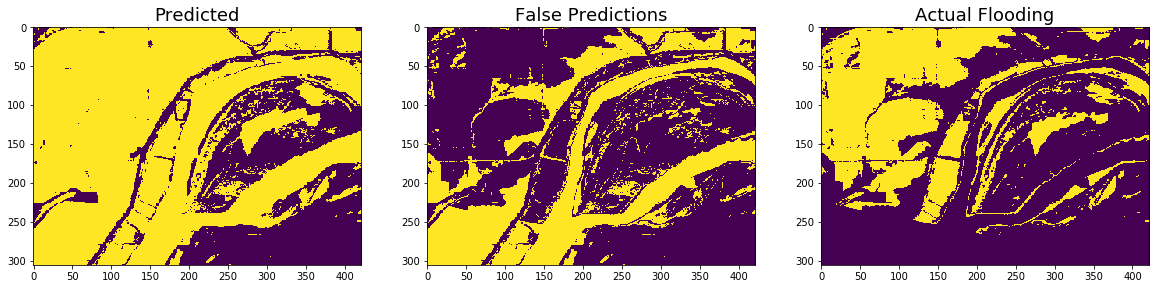

In [428]:
import matplotlib.pyplot as plt

# Path to folder with tifs
path = '../data/images/clouds1'
arr = rasterToArray(path)

# Convert image array to df just so we can keep track of columns
arr_df = pd.DataFrame(data=arr, columns=feat_list_train)

# Split into features and target
X = arr_df.drop('flooded', axis=1)
Y =  arr_df['flooded']
y_pred_img = clf.predict(X)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(Y, y_pred_img)))

# RMSE of test data
print('Test RMSE:', compute_rmse(y_pred_img, Y))

# Confusion matrix
print_cm(metrics.confusion_matrix(Y, y_pred_img)/len(y_pred_img)*100, labels=['notFlooded','Flooded'])
# Top row = predicted, left col = true

#================== Plotting results

# Plot predicted values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        preds = y_pred_img.reshape(shape)

# Plot incorrect values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        incorrect = np.empty(shape=(len(y_pred_img), ))

for actual, predicted, i in zip(Y, y_pred_img, range(len(incorrect))):
    if predicted != actual:
        incorrect[i] = 1
    else:
        incorrect[i] = 0

incorrect = incorrect.reshape(shape)

# Plot actual flooding
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        Ymap = np.array(Y)
        Ymap = Ymap.reshape(shape)


plt.figure(figsize=(20,13))
columns = 3
images = [preds, incorrect, Ymap]
titles = ['Predicted', 'False Predictions', 'Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Classification report for classifier LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0):
             precision    recall  f1-score   support

        0.0       1.00      0.52      0.69     94163
        1.0       0.27      1.00      0.42     16321

avg / total       0.89      0.59      0.65    110484


Test RMSE: 0.6380578129834087
               notFlooded    Flooded 
    notFlooded       44.5       40.7 
       Flooded        0.0       14.8 


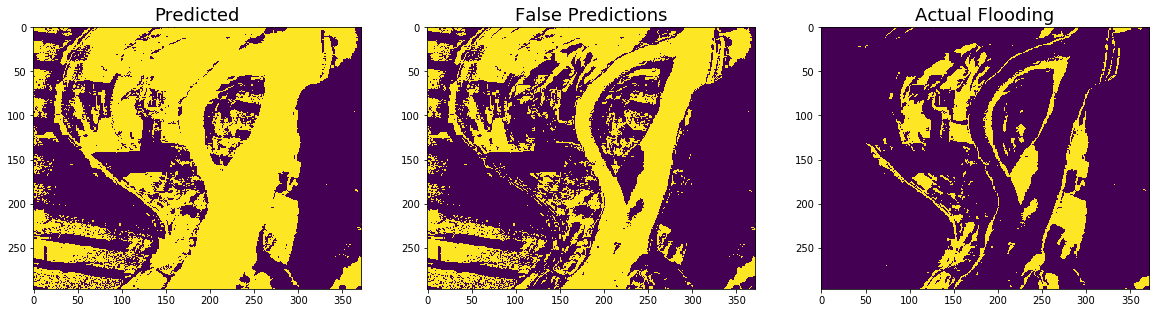

In [430]:
import matplotlib.pyplot as plt

# Path to folder with tifs
path = '../data/images/clouds2'
arr = rasterToArray(path)

# Convert image array to df just so we can keep track of columns
arr_df = pd.DataFrame(data=arr, columns=feat_list_train)

# Split into features and target
X = arr_df.drop('flooded', axis=1)
Y =  arr_df['flooded']
y_pred_img = clf.predict(X)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(Y, y_pred_img)))

# RMSE of test data
print('Test RMSE:', compute_rmse(y_pred_img, Y))

# Confusion matrix
print_cm(metrics.confusion_matrix(Y, y_pred_img)/len(y_pred_img)*100, labels=['notFlooded','Flooded'])
# Top row = predicted, left col = true

#================== Plotting results

# Plot predicted values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        preds = y_pred_img.reshape(shape)

# Plot incorrect values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        incorrect = np.empty(shape=(len(y_pred_img), ))

for actual, predicted, i in zip(Y, y_pred_img, range(len(incorrect))):
    if predicted != actual:
        incorrect[i] = 1
    else:
        incorrect[i] = 0

incorrect = incorrect.reshape(shape)

# Plot actual flooding
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        Ymap = np.array(Y)
        Ymap = Ymap.reshape(shape)


plt.figure(figsize=(20,13))
columns = 3
images = [preds, incorrect, Ymap]
titles = ['Predicted', 'False Predictions', 'Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)

In [381]:
# # The images aren't perfect squares or rectangles, but the arrays have to be rectangular. How are the gaps filled?
# with rasterio.open(path1 + '/stack/stack.tif', 'r') as ds:
#     check = pd.DataFrame(data=ds.read(1))
#     check.to_csv('../data/check.csv')


### Testing with images where flooding is not masked by perm water

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Classification report for classifier LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0):
             precision    recall  f1-score   support

        0.0       0.97      0.48      0.64     78724
        1.0       0.55      0.98      0.70     50408

avg / total       0.80      0.67      0.66    129132


Test RMSE: 0.5716484038228048
               notFlooded    Flooded 
    notFlooded       29.2       31.8 
       Flooded        0.9       38.2 


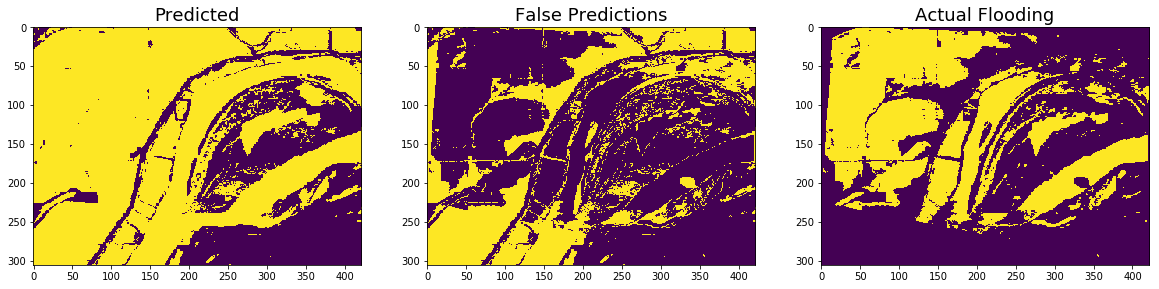

In [431]:
import matplotlib.pyplot as plt

# Path to folder with tifs
path = '../data/images/clouds1_noMask'
arr = rasterToArray(path)

# Convert image array to df just so we can keep track of columns
arr_df = pd.DataFrame(data=arr, columns=feat_list_train)

# Split into features and target
X = arr_df.drop('flooded', axis=1)
Y =  arr_df['flooded']
y_pred_img = clf.predict(X)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(Y, y_pred_img)))

# RMSE of test data
print('Test RMSE:', compute_rmse(y_pred_img, Y))

# Confusion matrix
print_cm(metrics.confusion_matrix(Y, y_pred_img)/len(y_pred_img)*100, labels=['notFlooded','Flooded'])
# Top row = predicted, left col = true

#================== Plotting results

# Plot predicted values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        preds = y_pred_img.reshape(shape)

# Plot incorrect values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        incorrect = np.empty(shape=(len(y_pred_img), ))

for actual, predicted, i in zip(Y, y_pred_img, range(len(incorrect))):
    if predicted != actual:
        incorrect[i] = 1
    else:
        incorrect[i] = 0

incorrect = incorrect.reshape(shape)

# Plot actual flooding
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        Ymap = np.array(Y)
        Ymap = Ymap.reshape(shape)


plt.figure(figsize=(20,13))
columns = 3
images = [preds, incorrect, Ymap]
titles = ['Predicted', 'False Predictions', 'Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Classification report for classifier LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0):
             precision    recall  f1-score   support

        0.0       0.99      0.58      0.73     83280
        1.0       0.43      0.98      0.60     27204

avg / total       0.85      0.68      0.70    110484


Test RMSE: 0.565366290786179
               notFlooded    Flooded 
    notFlooded       44.0       31.4 
       Flooded        0.6       24.1 


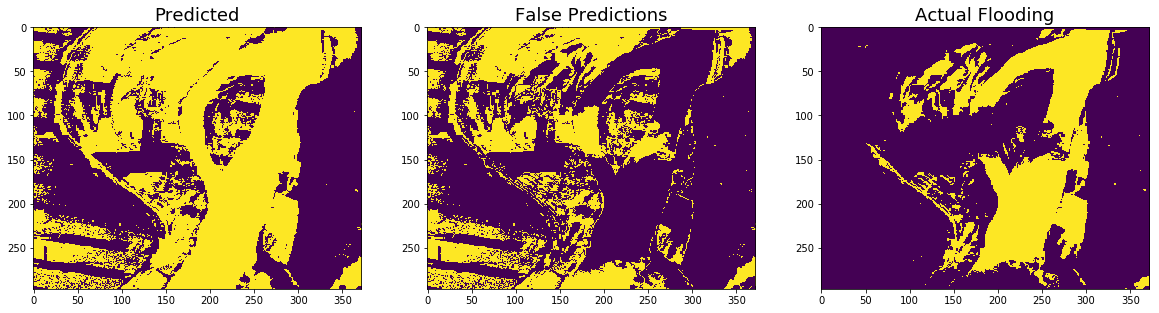

In [432]:
import matplotlib.pyplot as plt

# Weird, not sure what band those false positive striations are from

# Path to folder with tifs
path = '../data/images/clouds2_noMask'
arr = rasterToArray(path)

# Convert image array to df just so we can keep track of columns
arr_df = pd.DataFrame(data=arr, columns=feat_list_train)

# Split into features and target
X = arr_df.drop('flooded', axis=1)
Y =  arr_df['flooded']
y_pred_img = clf.predict(X)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(Y, y_pred_img)))

# RMSE of test data
print('Test RMSE:', compute_rmse(y_pred_img, Y))

# Confusion matrix
print_cm(metrics.confusion_matrix(Y, y_pred_img)/len(y_pred_img)*100, labels=['notFlooded','Flooded'])
# Top row = predicted, left col = true

#================== Plotting results

# Plot predicted values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        preds = y_pred_img.reshape(shape)

# Plot incorrect values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        incorrect = np.empty(shape=(len(y_pred_img), ))

for actual, predicted, i in zip(Y, y_pred_img, range(len(incorrect))):
    if predicted != actual:
        incorrect[i] = 1
    else:
        incorrect[i] = 0

incorrect = incorrect.reshape(shape)

# Plot actual flooding
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        Ymap = np.array(Y)
        Ymap = Ymap.reshape(shape)


plt.figure(figsize=(20,13))
columns = 3
images = [preds, incorrect, Ymap]
titles = ['Predicted', 'False Predictions', 'Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Classification report for classifier LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0):
             precision    recall  f1-score   support

        0.0       0.95      0.46      0.62     35439
        1.0       0.70      0.98      0.81     44553

avg / total       0.81      0.75      0.73     79992


Test RMSE: 0.4991241453699161
               notFlooded    Flooded 
    notFlooded       20.5       23.8 
       Flooded        1.1       54.6 


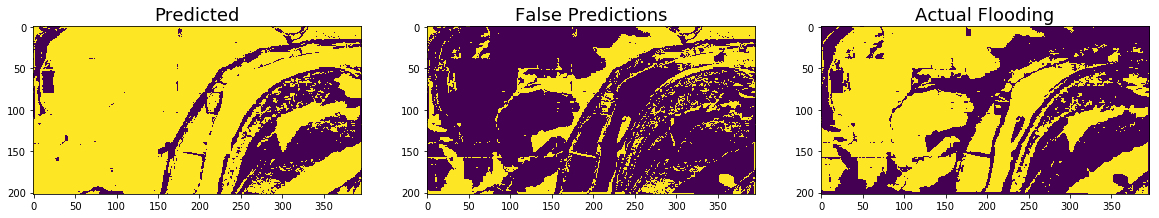

In [433]:
import matplotlib.pyplot as plt

# This one is a bit smaller and contains entirely clouds, no masked uncloud pixels

# Path to folder with tifs
path = '../data/images/clouds3'
arr = rasterToArray(path)

# Convert image array to df just so we can keep track of columns
arr_df = pd.DataFrame(data=arr, columns=feat_list_train)

# Split into features and target
X = arr_df.drop('flooded', axis=1)
Y =  arr_df['flooded']
y_pred_img = clf.predict(X)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(Y, y_pred_img)))

# RMSE of test data
print('Test RMSE:', compute_rmse(y_pred_img, Y))

# Confusion matrix
print_cm(metrics.confusion_matrix(Y, y_pred_img)/len(y_pred_img)*100, labels=['notFlooded','Flooded'])
# Top row = predicted, left col = true

#================== Plotting results

# Plot predicted values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        preds = y_pred_img.reshape(shape)

# Plot incorrect values
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        incorrect = np.empty(shape=(len(y_pred_img), ))

for actual, predicted, i in zip(Y, y_pred_img, range(len(incorrect))):
    if predicted != actual:
        incorrect[i] = 1
    else:
        incorrect[i] = 0

incorrect = incorrect.reshape(shape)

# Plot actual flooding
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape
        Ymap = np.array(Y)
        Ymap = Ymap.reshape(shape)


plt.figure(figsize=(20,13))
columns = 3
images = [preds, incorrect, Ymap]
titles = ['Predicted', 'False Predictions', 'Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)

In [479]:
# rasterToArray('../data/images/clouds1a_withNulls')
with rasterio.open('../data/images/clouds1a_withNulls/stack/stack.tif', 'r') as ds:
    ds = ds.read(15)
# plt.imshow(ds)
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
# ds = ds + 999999
# ds_sparse = csr_matrix(ds)
# First convert to a COO matrix using the nonmasked data, and indices of nonmasked data
ds_coo = coo_matrix((ds[np.where(ds != -999999)], (np.where(ds != -999999))))
ds_csr = ds_coo.tocsr()